In [1]:
import matplotlib
%matplotlib inline

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA

sns.set_context('poster')
sns.set_style('white')

pd.options.mode.chained_assignment = None  # default='warn'

import hdbscan
from collections import Counter
from collections import defaultdict
from numpy import random

from sklearn.cluster import KMeans

import time
import datetime

import matplotlib.dates as md
import datetime as dt

from itertools import combinations

In [2]:
def normalize(x, r):
    M = np.divide(x, r)
    M_norm = np.full_like(M, 0)
    for i in range(np.shape(M)[0]):
        rev = 1 - M[i, :]
        if np.dot(M[i, :], M[i, :]) > np.dot(rev, rev):
            M_norm[i, :] = rev
        else:
            M_norm[i, :] = M[i, :]
    return M_norm

In [3]:
def draw_PCA(f_pca, black_points=None):
    
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")

    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, alpha=0.2);
    if black_points is not None:
        plt.scatter(f_pca[black_points, 0], f_pca[black_points, 1], s=40, linewidth=0, c="black", alpha=1);
        plt.title("%s/%s points" % (np.sum(black_points), len(f_pca)))
    else:
        plt.title("%s points" % len(f_pca))

In [4]:
def filter_by_coverage(cur_r, bad_percent, bad_samples):
    def filter_row(row):
        num_of_samples = len(row)
        valid = np.sum(np.array(([(min_coverage < row) & (row < max_coverage)])))
        return num_of_samples - valid <= bad_samples

    min_coverage = np.percentile(cur_r, bad_percent, axis=0)
    max_coverage = np.percentile(cur_r, 100-bad_percent, axis=0)
    good_coverage = np.array([filter_row(row) for row in cur_r])
    return good_coverage

In [5]:
def draw_legend(class_colours, classes, right=False):
    recs = []
    for i in range(0, len(classes)):
        recs.append(mpatches.Rectangle((0,0), 1, 1, fc=class_colours[i]))
    if right:
        plt.legend(recs, classes, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    else:
        plt.legend(recs, classes)

In [6]:
def clusterization_kmeans(f, pca=True, num_of_comp=2, k=4):
    
    if pca:
        f_pca = PCA(n_components = num_of_comp).fit(f).transform(f)
        cur_f = f_pca
    else:
        cur_f = f
        f_pca = PCA(n_components = 2).fit(f).transform(f)

    clusterer = KMeans(n_clusters=k, random_state=0).fit(cur_f)
    
    print("\nNumber of clusters:\n", max(clusterer.labels_) + 1)
    
    plt.figure(figsize=(15, 8))
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    if pca:
        plt.title("Clustering %s primary components" % num_of_comp)
    else:
        plt.title("Clustering initial frequencies")        
    
    # Kelly’s 20 (except the first 2) Colours of Maximum Contrast
    color_palette = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    cluster_member_colors = [color_palette[x] for x in clusterer.labels_]
    plt.scatter(f_pca[:, 0], f_pca[:, 1], s=40, linewidth=0, c=cluster_member_colors, alpha=0.6);
    
    sizes_of_classes = Counter(clusterer.labels_)
    print(sizes_of_classes.get(-1, 0), "outliers\n")
    labels = [str(x) + ' - ' + str(sizes_of_classes[x]) for x in range(max(clusterer.labels_)+1)]
    draw_legend(color_palette, labels, right=True)  
        
    ans = []
    print("Medians in clusters:")
    for i in range(max(clusterer.labels_)+1):
        f_with_labels = f.copy()
        f_with_labels = np.hstack([f_with_labels, clusterer.labels_.reshape(len(f_with_labels),1)])
        col = f_with_labels[:, -1]
        idx = (col == i)
        print(i, np.round(np.median(f_with_labels[idx,:-1], axis=0), 2))
        ans.append(f_with_labels[idx,:-1])
    return ans

In [7]:
def plot_explained_variance(f, num_of_comp):
    var_exp = PCA(n_components=num_of_comp).fit(f).explained_variance_ratio_
    cum_var_exp = np.cumsum(var_exp)

    with plt.style.context('seaborn-whitegrid'):
        plt.figure(figsize=(8, 6))
        plt.bar(range(1,num_of_comp+1), var_exp, alpha=0.5, align='center',
                label='individual explained variance')
        plt.step(range(1,num_of_comp+1), cum_var_exp, where='mid',
                 label='cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal components')
        plt.legend(loc='best')
        plt.tight_layout()

In [8]:
def plot_dates(dates, selected=None):
    plt.figure(figsize=(19, 2))
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)

    timestampes_all = [time.mktime(datetime.datetime.strptime(s, "%Y_%m_%d").timetuple()) for s in dates]
    points_all = [dt.datetime.fromtimestamp(ts) for ts in timestampes_all]

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=75)
    ax = plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_yticklabels([])

    plt.scatter(points_all, [0] * len(points_all), edgecolor='black', linewidth='2', label="all");
    
    if selected is not None:
        points_selected = [points_all[i] for i in range(len(points_all)) if i in selected]
        plt.scatter(points_selected, [0] * len(points_selected), color="red", 
                    edgecolor='black', linewidth='1', label="selected");
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [205]:
def plot_strains_on_dates(dates, selected, strains):
    plt.figure(figsize=(19, 2))
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)

    timestampes_all = [time.mktime(datetime.datetime.strptime(s, "%Y_%m_%d").timetuple()) for s in dates]
    points_all = [dt.datetime.fromtimestamp(ts) for ts in timestampes_all]

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=75)
    ax = plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_yticklabels([])
    
    plt.scatter(points_all, [0] * len(points_all), color="grey", label="not selected", alpha=0.5);
    
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#7f7e80', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    
    points_selected = [points_all[i] for i in range(len(points_all)) if i in selected]
    for k in range(len(strains)):
        strain = strains[k]
        points_cur_strain = [points_selected[i] for i in range(len(points_selected)) if strain[i] == 1]
        plt.scatter(points_cur_strain, [0] * len(points_cur_strain), color=colors[k], 
                    edgecolor='black', linewidth='1', label="strain %s" % (k+1));
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [10]:
def delete_almost_zero(x, r, Ncut = 6):
    
    print("Delete zero and almost zero profiles:")
    good_ind = [i for i in range(np.shape(x)[0]) 
                if not ((np.abs(r[i, :] - x[i, :]) <= Ncut).all() or (x[i, :] <= Ncut).all())]
    print(len(good_ind), "remained")

    x = x[good_ind, :]
    r = r[good_ind, :]
    
    return x, r

In [82]:
def brute_force(clusters, remove_0=True, err=0.5, bad_samples=0):
    np.set_printoptions(precision=2)

    def are_almost_equal(row1, row2, e=0.04):
        abs_error = np.abs(row1 - row2)
        unvalid = np.sum(np.array([abs_error > e]))
        return unvalid <= bad_samples

    n = len(clusters)

    if remove_0:
        ind = -1
        cur_sum = float("Inf")
        for i in range(n):
            row = clusters[i]
            if cur_sum > np.sum(row):
                cur_sum = np.sum(row)
                ind = i
        print("Cluster for zero profiles:")
        print('', clusters[ind], "\n")
        clusters = np.delete(clusters, ind, axis=0)
        n -= 1

    unprocessed = set(range(n))
    labels = [[] for i in range(n)]
    num_strains = 0
    strains = []

    pairwise_sums = np.empty((n, n, len(clusters[0])))
    for i in range(n):
        for j in range(n):
            pairwise_sums[i][j] = clusters[i] + clusters[j]

    for i in range(n):
        is_strain = True
        for ii in range(n):
            for jj in range(ii+1, n):
                if are_almost_equal(clusters[i], pairwise_sums[ii][jj]):
                    is_strain = False
                    #labels[i].append([ii, jj])
        if is_strain:
            num_strains += 1
            labels[i] = num_strains
            unprocessed.remove(i)
            strains.append(i)

    combs = []
    for i in range(1, len(strains)+1):
        combs += list(combinations(strains, i))
    
    comb_sums = {}
    comb_names = {}
    for comb in combs:
        comb_sums[comb] = np.zeros(len(clusters[0]))
        for item in comb:
            comb_sums[comb] += clusters[item]
        comb_names[comb] = [labels[e] for e in comb]
            
    for i in unprocessed:
        for comb in comb_sums.keys():
            if are_almost_equal(clusters[i], comb_sums[comb]):
                labels[i].append(comb_names[comb])
            if len(labels[i]) == 1:
                labels[i] = labels[i][0]
                
    for i in strains + list(unprocessed) :
        print(" ".join(['%6s' % np.around(clusters[i],2)[j] for j in range(len(clusters[i]))]), 
              ' -- ', labels[i])
        
    ans = []
    for s in strains:
        ans.append(np.rint(clusters[s]))
    return ans

# Разберемся с порядком образцов

In [12]:
def sample_name_to_date(name):
    name = name.split('_')
    if len(name[1]) == 1:
        name[1] = '0' + name[1]
    if len(name[2]) == 1:
        name[2] = '0' + name[2]
    name = name[3] + '_' + name[1] + '_' + name[2]
    return name    

In [13]:
SAMPLES = ['LS_10_27_2013', 'LS_11_6_2012', 'LS_12_7_2014', 'LS_4_3_2012', 'LS_6_9_2013', 'LS_8_22_2014', 
           'LS_9_24_2013', 'LS_11_10_2013', 'LS_12_14_2013', 'LS_2_17_2014', 'LS_5_4_2014', 'LS_7_14_2013', 
           'LS_8_25_2014', 'LS_9_28_2014', 'LS_11_16_2014', 'LS_12_28_2011', 'LS_3_23_2014', 'LS_6_16_2014', 
           'LS_8_10_2013', 'LS_8_7_2012', 'LS_9_3_2013']

Выясним порядок, в котором надо пересортировать образцы (по датам).

In [14]:
samples_reordered = SAMPLES.copy()
for i in range(len(samples_reordered)):
    samples_reordered[i] = sample_name_to_date(samples_reordered[i])
dates_all, order = zip(*sorted(zip(samples_reordered, range(len(samples_reordered)))))
print(order)
print(dates_all)

(15, 3, 19, 1, 4, 11, 18, 20, 6, 0, 7, 8, 9, 16, 10, 17, 5, 12, 13, 14, 2)
('2011_12_28', '2012_04_03', '2012_08_07', '2012_11_06', '2013_06_09', '2013_07_14', '2013_08_10', '2013_09_03', '2013_09_24', '2013_10_27', '2013_11_10', '2013_12_14', '2014_02_17', '2014_03_23', '2014_05_04', '2014_06_16', '2014_08_22', '2014_08_25', '2014_09_28', '2014_11_16', '2014_12_07')


In [15]:
#print([SAMPLES[i] for i in order])

## Начинаем обрабатывать

In [16]:
r_all_smpls = np.genfromtxt("smarr_ecoli_K12/matrices/R_all", dtype=int, delimiter=' ')
x_all_smpls = np.genfromtxt("smarr_ecoli_K12/matrices/X_all", dtype=int, delimiter=' ')

print("%s sites" % len(r_all_smpls))

85532 sites


In [17]:
r_all_smpls = r_all_smpls[:, order]
x_all_smpls = x_all_smpls[:, order]

In [18]:
x_all_smpls, r_all_smpls = delete_almost_zero(x_all_smpls, r_all_smpls)

Delete zero and almost zero profiles:
84088 remained


In [19]:
good_cov_all_smpls = filter_by_coverage(r_all_smpls, 15, 4)

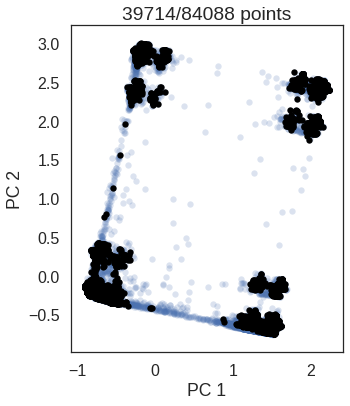

In [20]:
f_all_smpls = np.divide(x_all_smpls, r_all_smpls)
draw_PCA(PCA(n_components=2).fit(f_all_smpls).transform(f_all_smpls),
         good_cov_all_smpls)


Number of clusters:
 4
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    1.    1.    0.99  1.    1.    1.    1.    1.    0.
  0.    0.    0.    0.    0.01  0.99  0.97  0.  ]
1 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.]
2 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.98  1.    1.    1.    0.22  0.03  0.    0.02  0.9 ]
3 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  0.99  1.    1.    1.    0.23  0.04  1.    1.    1.  ]


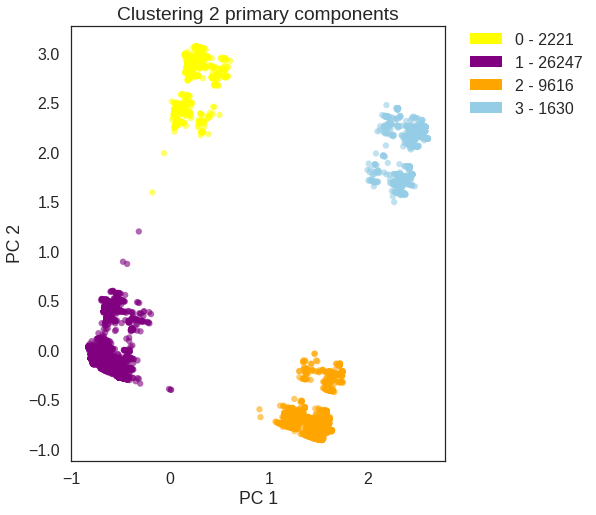

In [21]:
clusters_all_smpls = clusterization_kmeans(f_all_smpls[good_cov_all_smpls], pca=True, num_of_comp=2)

In [22]:
for i in range(len(clusters_all_smpls)):
    pca_all = PCA(n_components=2).fit(f_all_smpls[good_cov_all_smpls]).transform(clusters_all_smpls[i])
    #draw_PCA(pca_all)

    pca_cluster = PCA(n_components=2).fit(clusters_all_smpls[i]).transform(clusters_all_smpls[i])
    #draw_PCA(pca_cluster)

## Уберем некоторые образцы

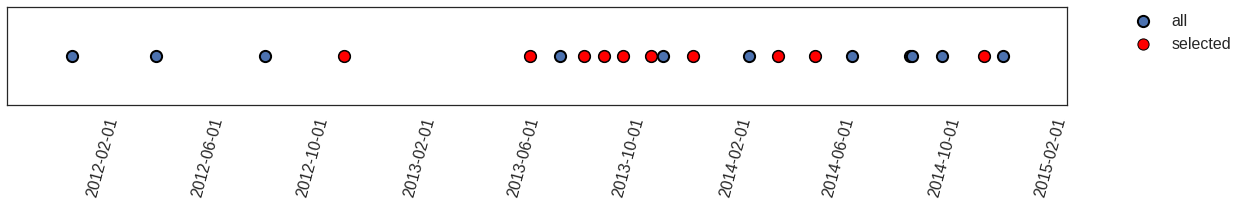

In [23]:
list_to_delete = [0, 1, 2, 5, 10, 12, 15, 16, 17, 18, 20] 
list_to_remain = set(range(21)) - set(list_to_delete)

plot_dates(dates_all, list_to_remain)

In [24]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
56168 remained


In [25]:
good_coverage_ind = filter_by_coverage(r, 25, 2)

Без нормализации

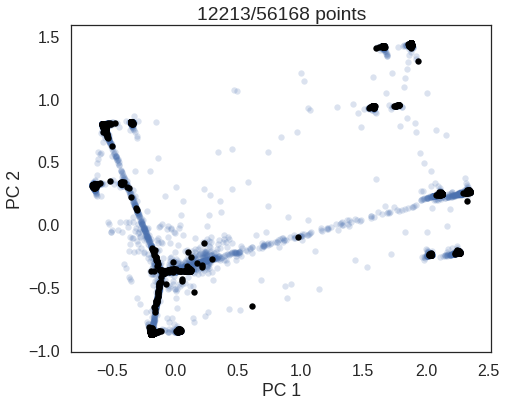

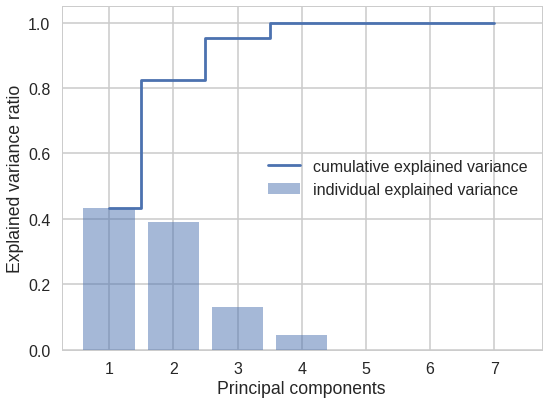

In [26]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], 7)

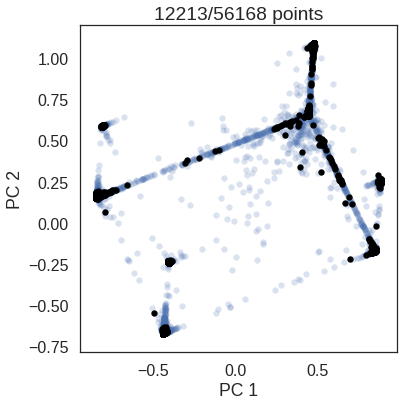

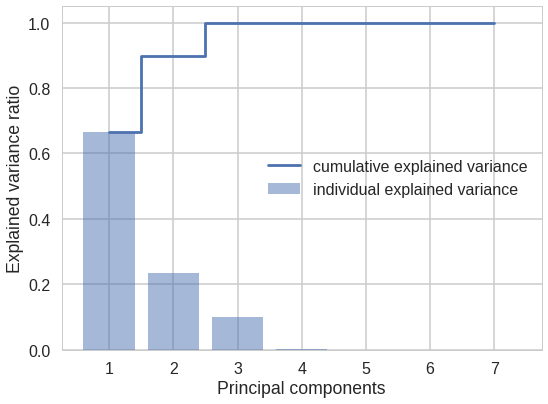

In [27]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], 7)


Number of clusters:
 8
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    1.    1.    0.02]
1 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
3 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    0.02]
4 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    1.  ]
5 [ 0.    0.    0.    0.    0.02  0.01  0.    0.    0.    0.01]
6 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
7 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]


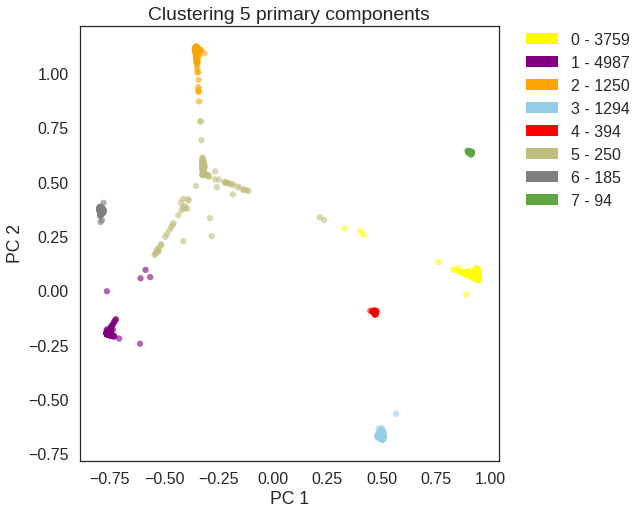

In [28]:
f = normalize(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=8, num_of_comp=5)


Number of clusters:
 16
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    1.    1.    0.02]
1 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2 [ 0.    1.    0.99  1.    1.    1.    1.    0.    0.    0.98]
3 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
4 [ 0.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
5 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    0.02]
6 [ 0.    1.    0.99  1.    1.    1.    1.    0.    0.    0.  ]
7 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    0.02]
8 [ 1.    1.    0.99  1.    1.    1.    1.    0.    0.    0.98]
9 [ 0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.01]
10 [ 1.    0.    0.    0.    0.    0.    0.    0.    0.    0.98]
11 [ 1.    0.    0.01  0.    0.    0.    0.    1.    1.    1.  ]
12 [ 0.    1.    1.    1.    1.    1.    1.    1.    0.99  0.02]
13 [ 0.  0.  0.  0.  0.  0.  0.  1.  1.  1.]
14 [ 1.    1.    0.99  1.    1.    1.    1.    0.    0.01  0.  ]
15 [ 1.    1.    1.    1.    0.96  0.

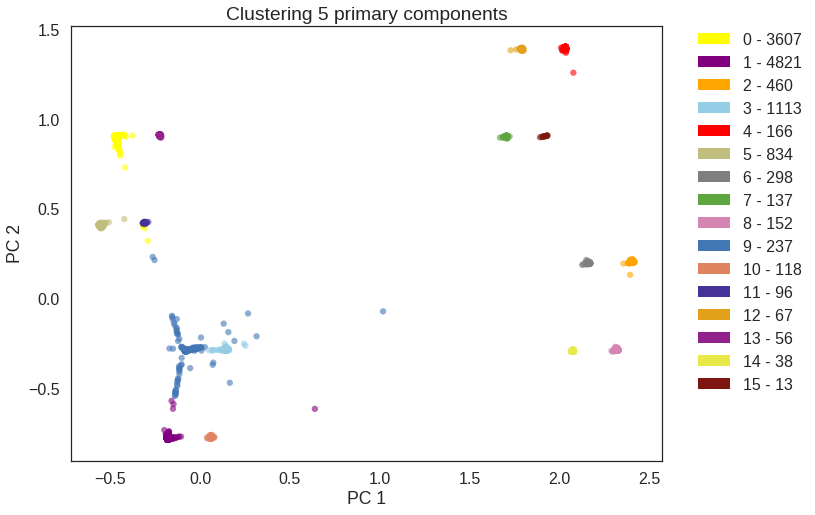

In [29]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=16, num_of_comp=5)

In [30]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.01  0.    0.    0.    0.    0.01] 

   0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   0.02  --  1
   1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  2
   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.98  --  3
   0.0    1.0   0.99    1.0    1.0    1.0    1.0    0.0    0.0    0.0  --  4
   0.0    1.0   0.99    1.0    1.0    1.0    1.0    0.0    0.0   0.98  --  [3, 4]
   0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  --  [1, 3, 4]
   1.0    0.0   0.01    0.0    0.0    0.0    0.0    1.0    1.0   0.02  --  [1, 2]
   1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   0.02  --  [1, 2, 4]
   1.0    1.0   0.99    1.0    1.0    1.0    1.0    0.0    0.0   0.98  --  [2, 3, 4]
   1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.98  --  [2, 3]
   1.0    0.0   0.01    0.0    0.0    0.0    0.0    1.0    1.0    1.0  --  [1, 2, 3]
   0.0    1.0 

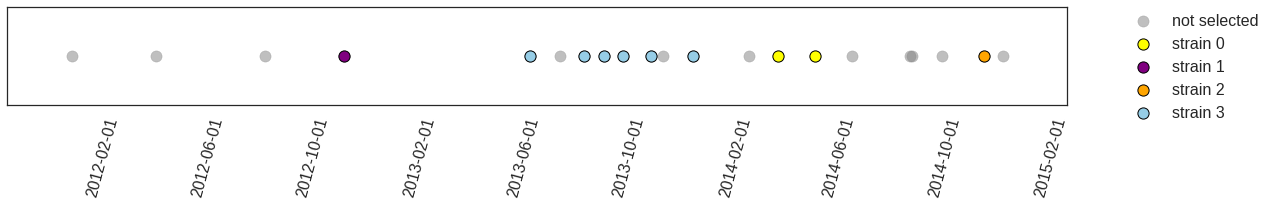

In [32]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## Выберем другие дни

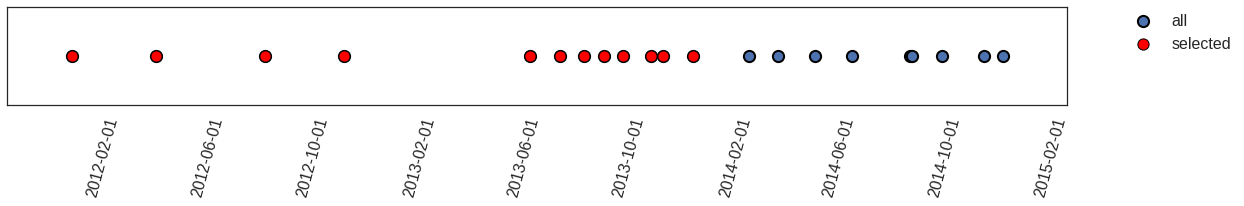

In [66]:
list_to_remain = list(range(12)) 
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [67]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
68732 remained


In [68]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

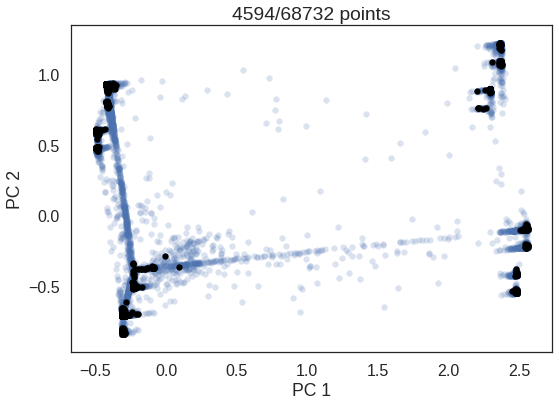

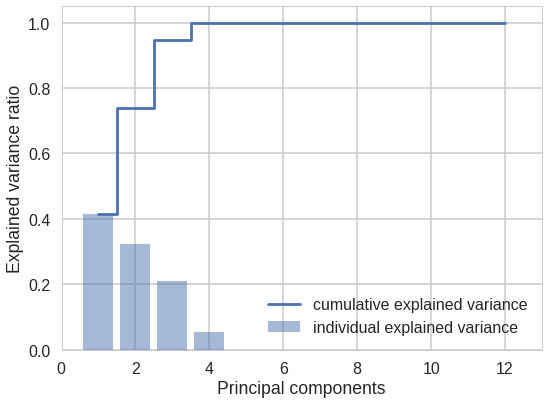

In [69]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 15
0 outliers

Medians in clusters:
0 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
2 [ 0.    0.    0.98  1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
3 [ 0.    0.    0.    0.    1.    1.    0.99  1.    1.    1.    1.    1.  ]
4 [ 1.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
5 [ 1.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
6 [ 0.    1.    0.99  1.    1.    1.    1.    1.    1.    1.    1.    1.  ]
7 [ 1.    1.    0.01  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
8 [ 1.    1.    1.    1.    0.01  0.    0.    0.    0.    0.    0.    0.  ]
9 [ 0.    1.    0.98  1.    0.    0.    0.    0.    0.    0.    0.    0.  ]
10 [ 0.    1.    0.    0.    0.99  1.    0.99  1.    1.    1.    1.    1.  ]
11 [ 0.    0.    1.    1.    0.99  1.    0.99  1.    1.    1.    1.    1.  ]
12 [ 1.    0.    0.01  0.    1.    1.    1.    1.    1.    1.    1.    1.  ]
13 [ 0.    0.    0.    0.    0.    0.    0.    

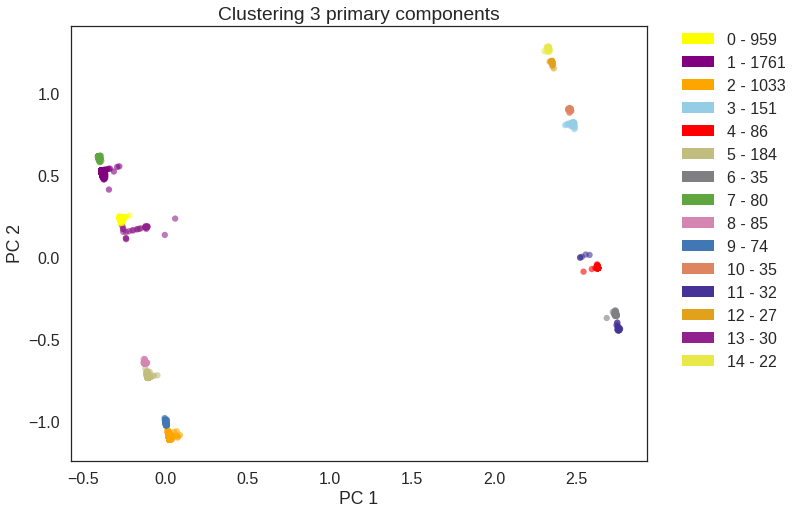

In [71]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=15, num_of_comp=3)

In [72]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.09  0.04  0.14  0.  ] 

   0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  1
   1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  2
   0.0    0.0   0.98    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  3
   0.0    0.0    0.0    0.0    1.0    1.0   0.99    1.0    1.0    1.0    1.0    1.0  --  4
   1.0    0.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  --  [2, 3, 4]
   1.0    0.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  [2, 3]
   0.0    1.0   0.99    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0  --  [1, 3, 4]
   1.0    1.0   0.01    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  [1, 2]
   1.0    1.0    1.0    1.0   0.01    0.0    0.0    0.0    0.0    0.0    0.0    0.0  --  [1, 2, 3]
   0.0    1.0   0.98    1.0    0.0    0.0  

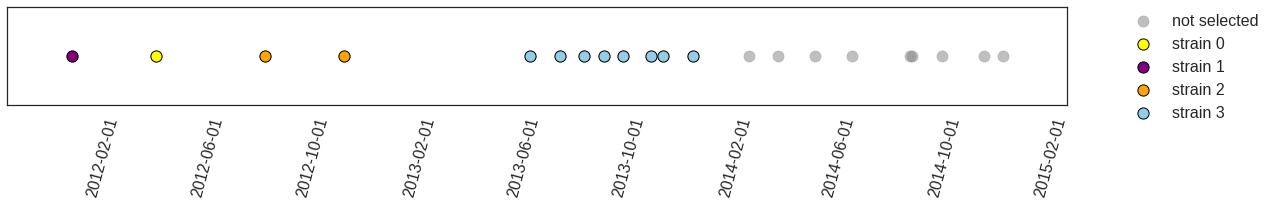

In [73]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

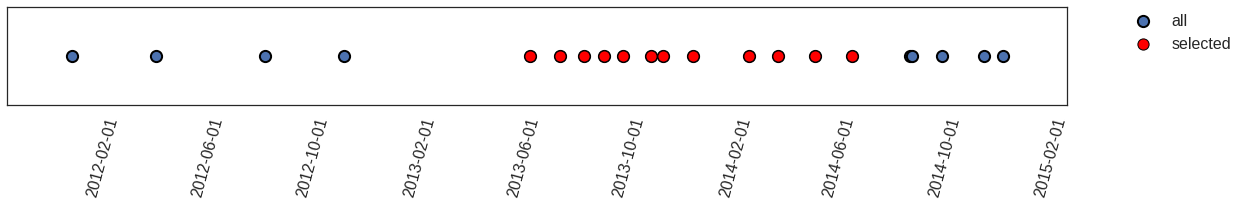

In [74]:
list_to_remain = list(range(4,16))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [75]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
31080 remained


In [76]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

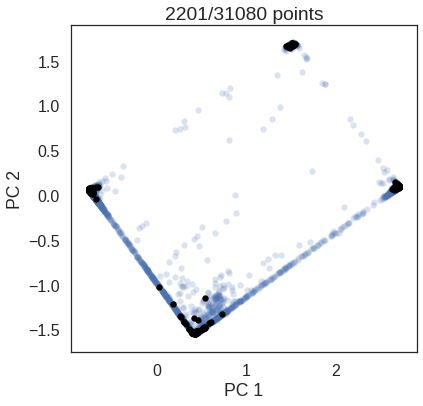

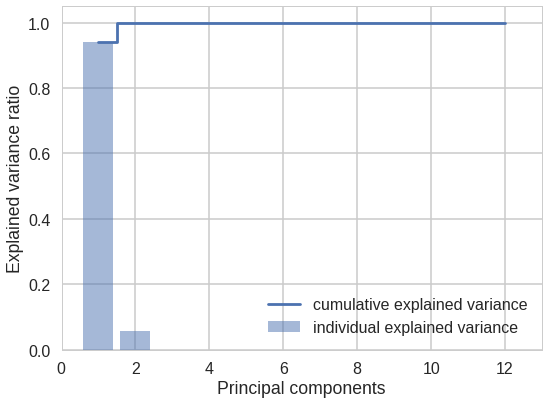

In [77]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 4
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.98  1.    1.    1.  ]
1 [ 0.99  1.    0.99  1.    1.    1.    1.    1.    0.    0.    0.    0.  ]
2 [ 0.    0.    0.    0.    0.03  0.01  0.05  0.    0.    0.    0.    0.  ]
3 [ 1.    1.    1.    1.    0.97  0.98  0.9   1.    0.99  1.    1.    1.  ]


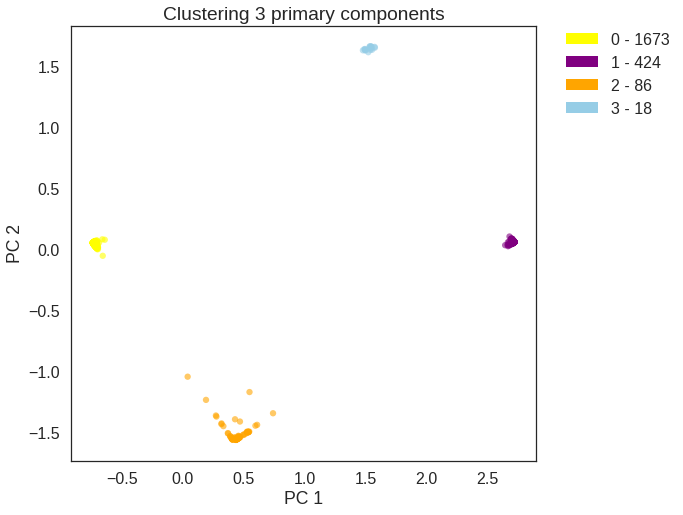

In [79]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=4, num_of_comp=3)

In [83]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=1)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.03  0.01  0.05  0.    0.    0.    0.    0.  ] 

   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.98    1.0    1.0    1.0  --  1
  0.99    1.0   0.99    1.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0  --  2
   1.0    1.0    1.0    1.0   0.97   0.98    0.9    1.0   0.99    1.0    1.0    1.0  --  [1, 2]


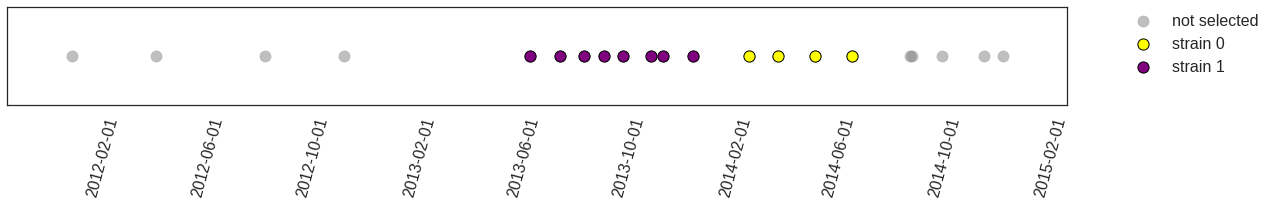

In [84]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

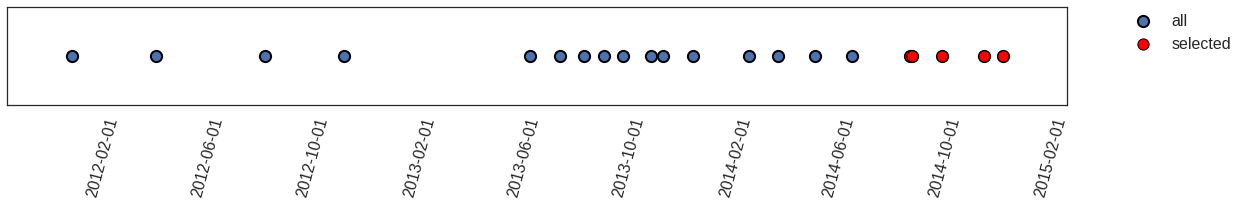

In [93]:
list_to_remain = list(range(16,21))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [94]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
44771 remained


In [101]:
good_coverage_ind = filter_by_coverage(r, 25, 0)

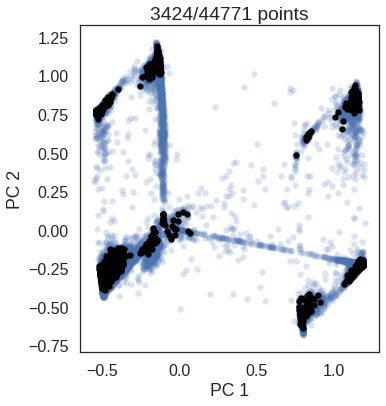

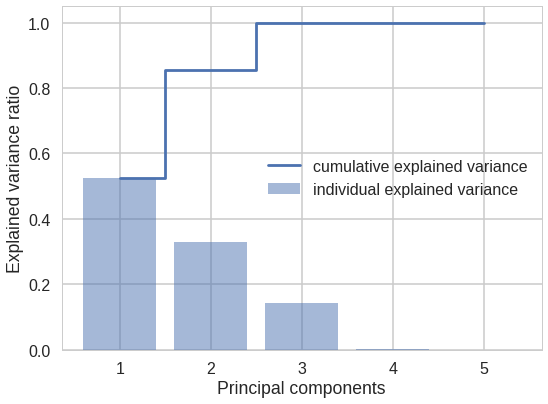

In [102]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))

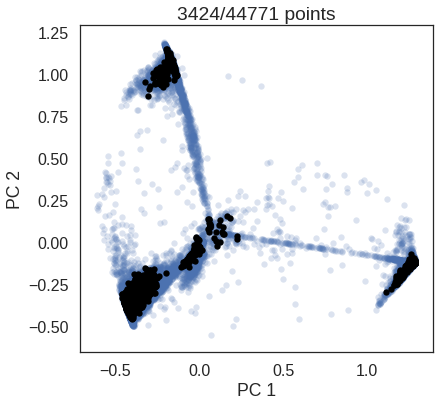

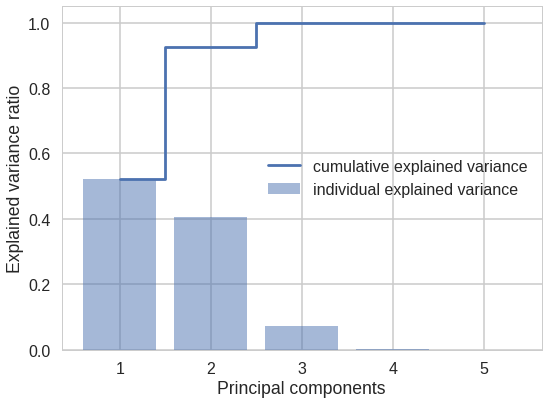

In [103]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 7
0 outliers

Medians in clusters:
0 [ 0.    0.    1.    0.98  0.  ]
1 [ 0.22  0.03  0.    0.02  0.89]
2 [ 0.78  0.96  0.    0.    0.  ]
3 [ 0.    0.    0.    0.    0.21]
4 [ 0.79  0.97  1.    0.98  0.  ]
5 [ 0.2   0.04  1.    1.    1.  ]
6 [ 1.    0.99  0.    0.01  0.98]


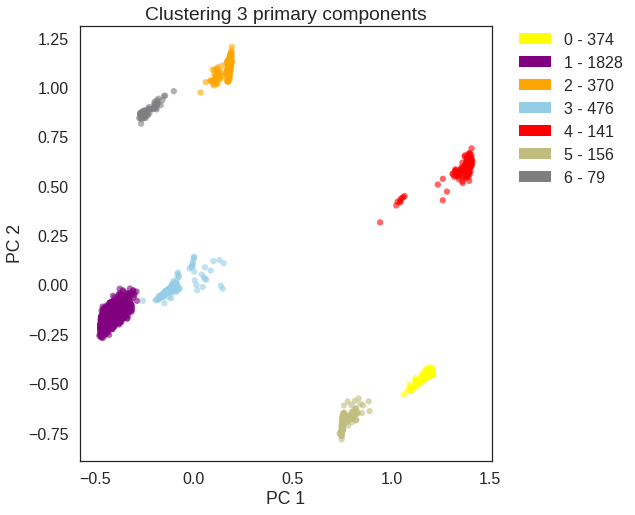

In [117]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=7, num_of_comp=3)

In [108]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=1)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.21] 

   0.0    0.0    1.0   0.98    0.0  --  1
  0.22   0.03    0.0   0.02   0.89  --  2
  0.78   0.96    0.0    0.0    0.0  --  3
  0.79   0.97    1.0   0.98    0.0  --  [1, 3]
   0.2   0.04    1.0    1.0    1.0  --  [1, 2]
   1.0   0.99    0.0   0.01   0.98  --  [2, 3]


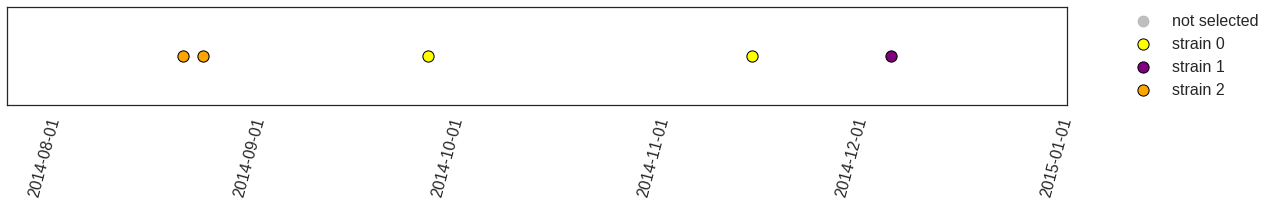

In [114]:
plot_strains_on_dates(dates_all[16:], [x-16 for x in list_to_remain], strains)

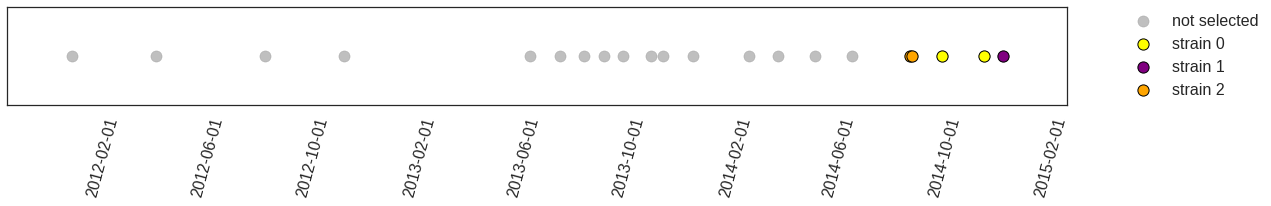

In [115]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

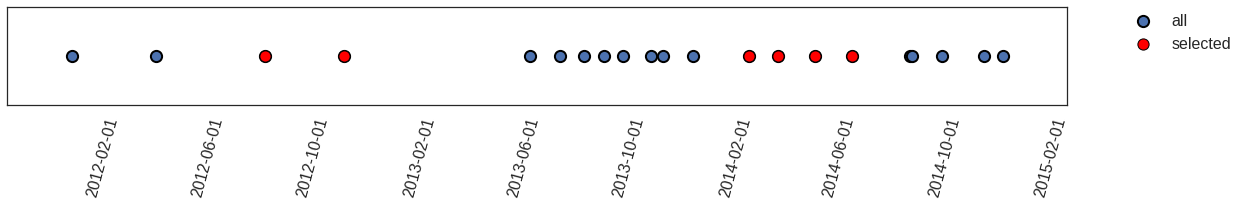

In [131]:
list_to_remain = list(range(2,4)) + list(range(12,16))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [132]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
40125 remained


In [133]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

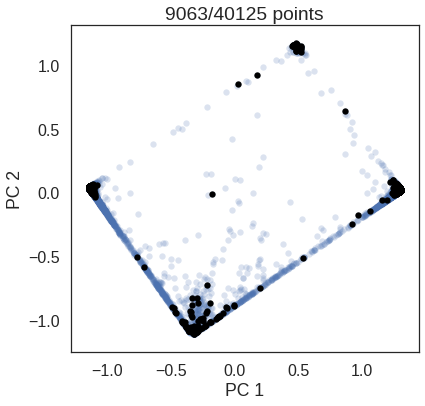

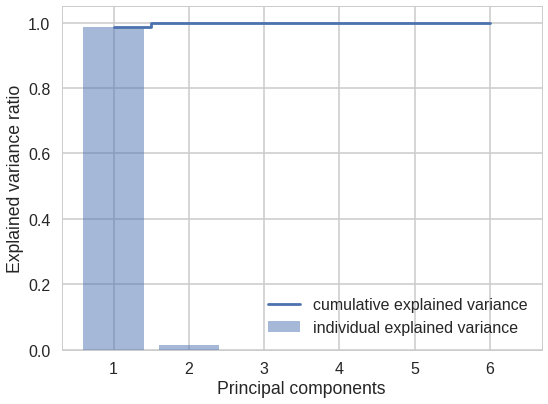

In [134]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 4
0 outliers

Medians in clusters:
0 [ 0.98  1.    0.    0.    0.    0.  ]
1 [ 0.    0.    0.98  1.    1.    1.  ]
2 [ 0.05  0.    0.01  0.    0.01  0.01]
3 [ 0.94  1.    0.98  1.    0.99  1.  ]


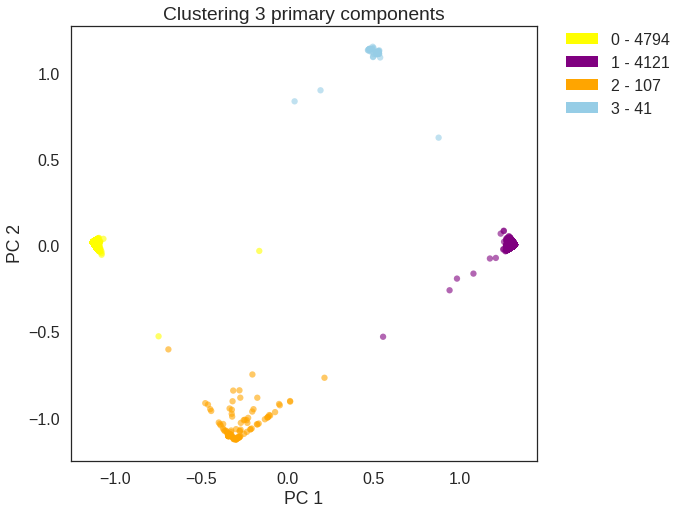

In [136]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=4, num_of_comp=3)

In [137]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=1)

Cluster for zero profiles:
 [ 0.05  0.    0.01  0.    0.01  0.01] 

  0.98    1.0    0.0    0.0    0.0    0.0  --  1
   0.0    0.0   0.98    1.0    1.0    1.0  --  2
  0.94    1.0   0.98    1.0   0.99    1.0  --  [1, 2]


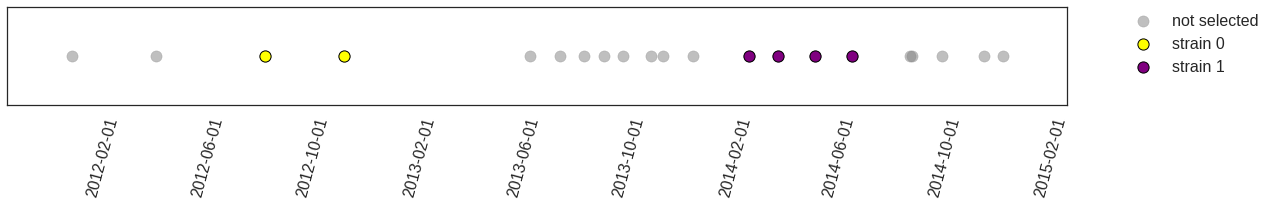

In [139]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

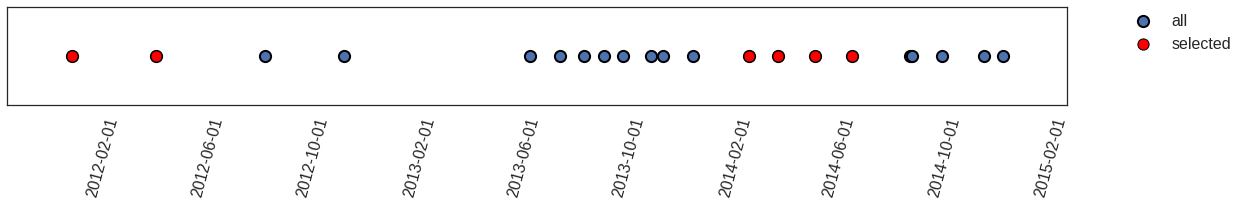

In [140]:
list_to_remain = list(range(2)) + list(range(12,16))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [141]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
49738 remained


In [142]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

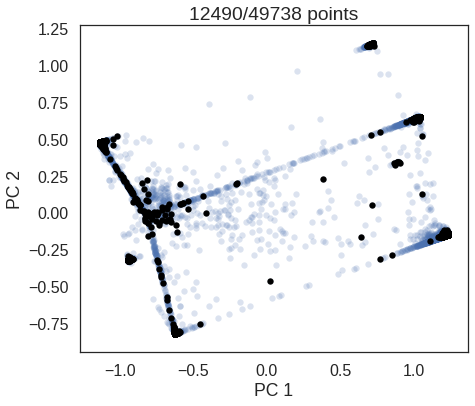

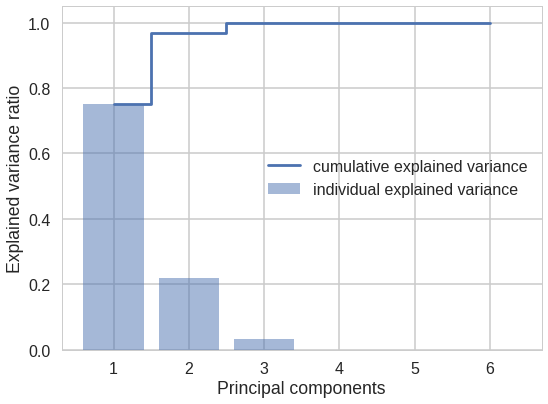

In [143]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 8
0 outliers

Medians in clusters:
0 [ 1.    0.    0.99  1.    1.    1.  ]
1 [ 0.  1.  0.  0.  0.  0.]
2 [ 1.  0.  0.  0.  0.  0.]
3 [ 0.    0.    0.98  1.    0.99  0.99]
4 [ 1.  1.  0.  0.  0.  0.]
5 [ 0.    1.    0.99  1.    1.    1.  ]
6 [ 0.    0.07  0.    0.    0.    0.  ]
7 [ 1.    1.    0.97  1.    0.98  1.  ]


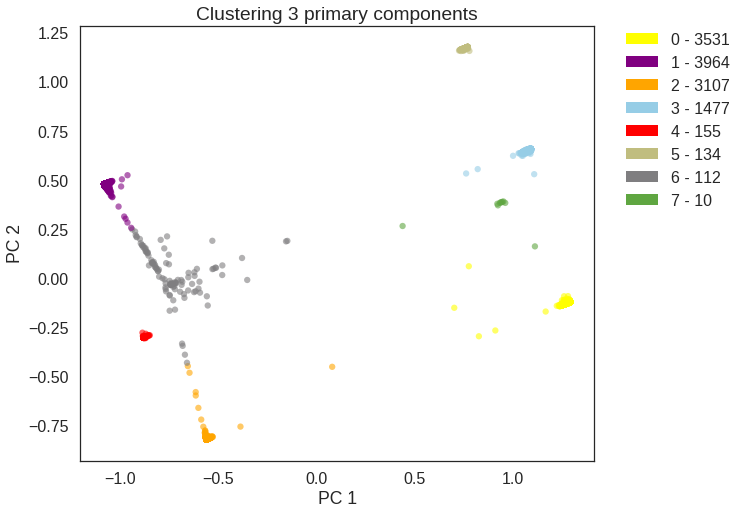

In [146]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=8, num_of_comp=3)

In [149]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=0)

Cluster for zero profiles:
 [ 0.    0.07  0.    0.    0.    0.  ] 

   0.0    1.0    0.0    0.0    0.0    0.0  --  1
   1.0    0.0    0.0    0.0    0.0    0.0  --  2
   0.0    0.0   0.98    1.0   0.99   0.99  --  3
   1.0    0.0   0.99    1.0    1.0    1.0  --  [2, 3]
   1.0    1.0    0.0    0.0    0.0    0.0  --  [1, 2]
   0.0    1.0   0.99    1.0    1.0    1.0  --  [1, 3]
   1.0    1.0   0.97    1.0   0.98    1.0  --  [1, 2, 3]


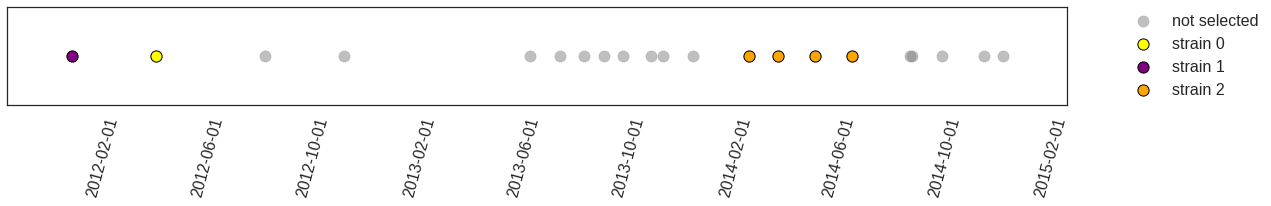

In [150]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

# Объединяем

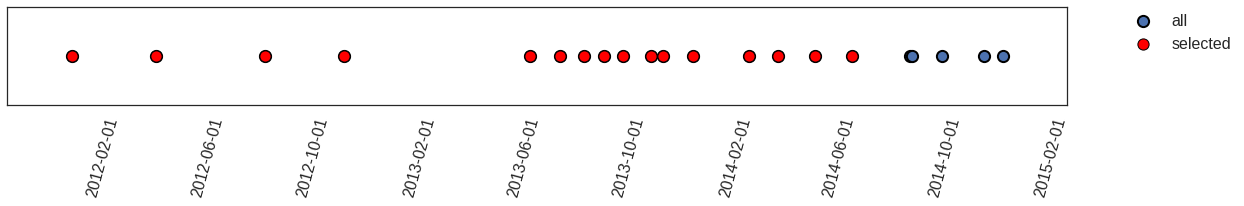

In [153]:
list_to_remain = list(range(16))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [155]:
strains = [""] * 5
strains[0] = [1] + [0]*15
strains[1] = [0, 1] + [0]*14
strains[2] = [0,0] + [1,1] + [0]*12
strains[3] = [0]*4 + [1]*8 + [0]*4
strains[4] = [0]*12 + [1]*4

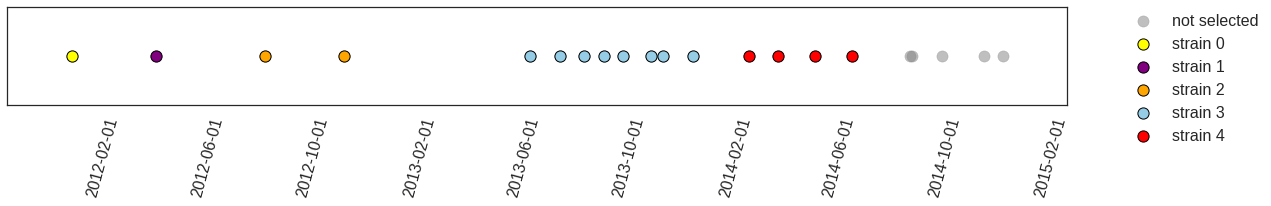

In [156]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

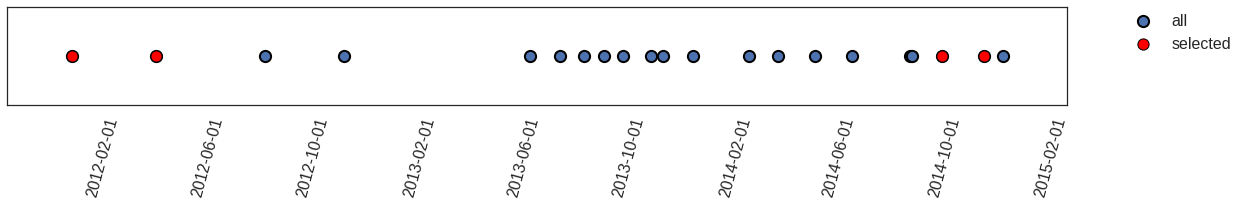

In [157]:
list_to_remain = list(range(2)) + list(range(18,20))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [158]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
52933 remained


In [159]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

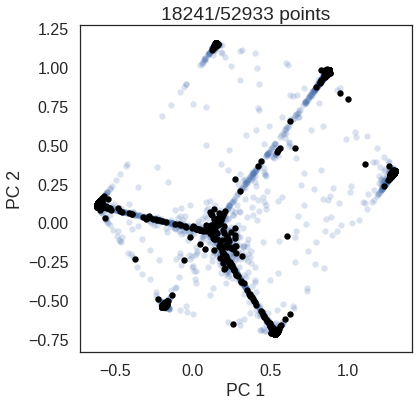

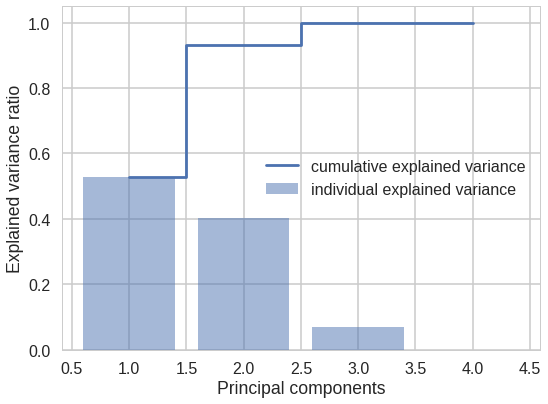

In [160]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 7
0 outliers

Medians in clusters:
0 [ 1.    0.    0.    0.01]
1 [ 0.  1.  0.  0.]
2 [ 0.    0.    1.    0.98]
3 [ 1.    1.    0.    0.01]
4 [ 1.  0.  1.  1.]
5 [ 0.    1.    1.    0.99]
6 [ 0.    0.    0.03  0.05]


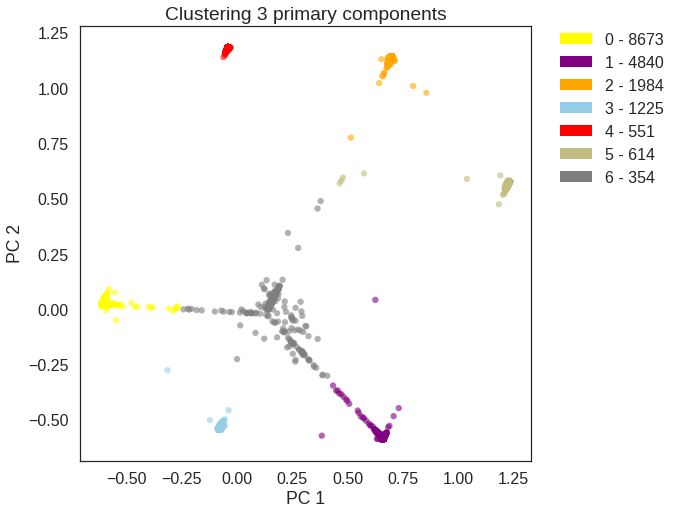

In [164]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=7, num_of_comp=3)

In [165]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=0)

Cluster for zero profiles:
 [ 0.    0.    0.03  0.05] 

   1.0    0.0    0.0   0.01  --  1
   0.0    1.0    0.0    0.0  --  2
   0.0    0.0    1.0   0.98  --  3
   1.0    1.0    0.0   0.01  --  [1, 2]
   1.0    0.0    1.0    1.0  --  [1, 3]
   0.0    1.0    1.0   0.99  --  [2, 3]


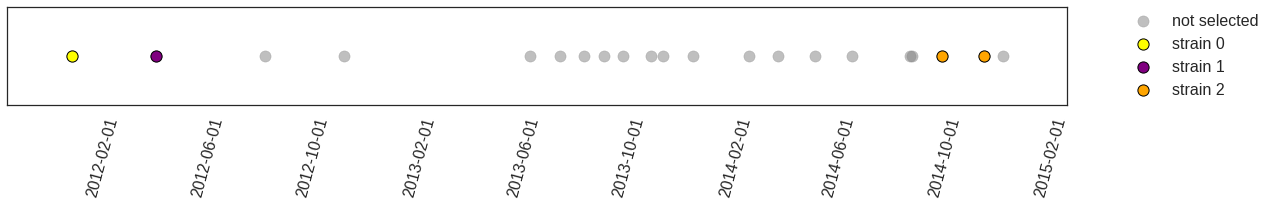

In [166]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

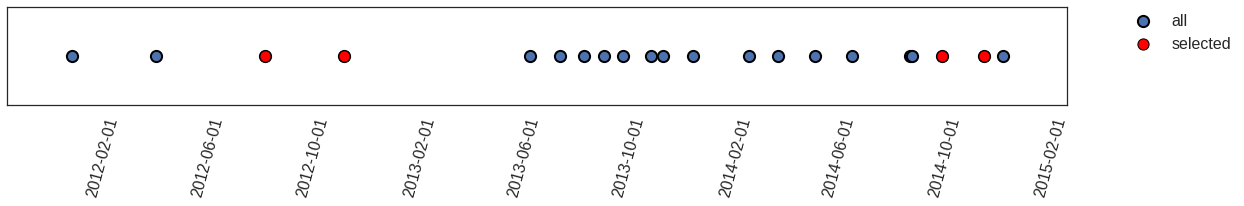

In [167]:
list_to_remain = list(range(2,4)) + list(range(18,20))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [168]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
35031 remained


In [169]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

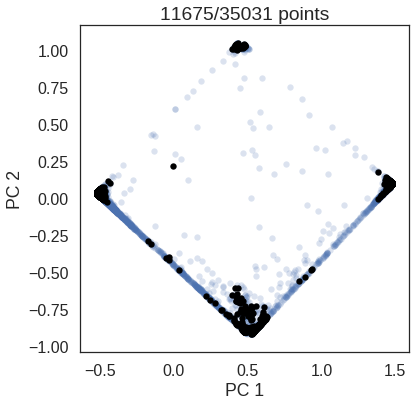

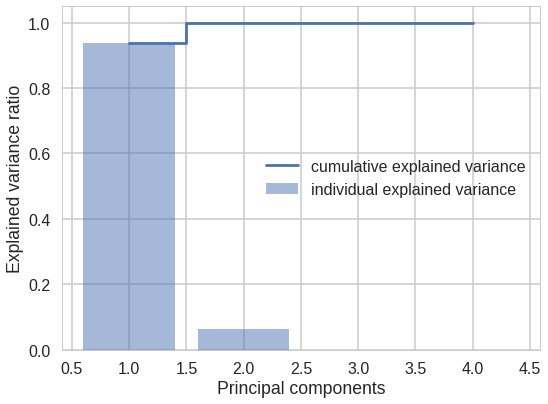

In [170]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 4
0 outliers

Medians in clusters:
0 [ 0.99  1.    0.    0.  ]
1 [ 0.    0.    1.    0.99]
2 [ 0.    0.    0.01  0.05]
3 [ 0.97  1.    1.    0.96]


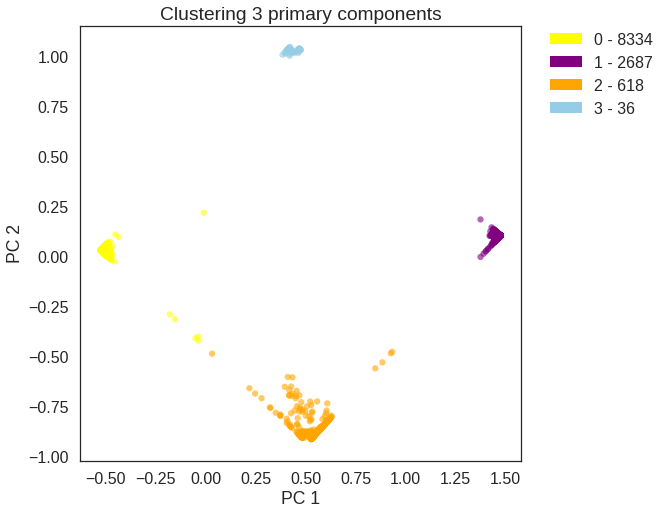

In [175]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=4, num_of_comp=3)

In [176]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=0)

Cluster for zero profiles:
 [ 0.    0.    0.01  0.05] 

  0.99    1.0    0.0    0.0  --  1
   0.0    0.0    1.0   0.99  --  2
  0.97    1.0    1.0   0.96  --  [1, 2]


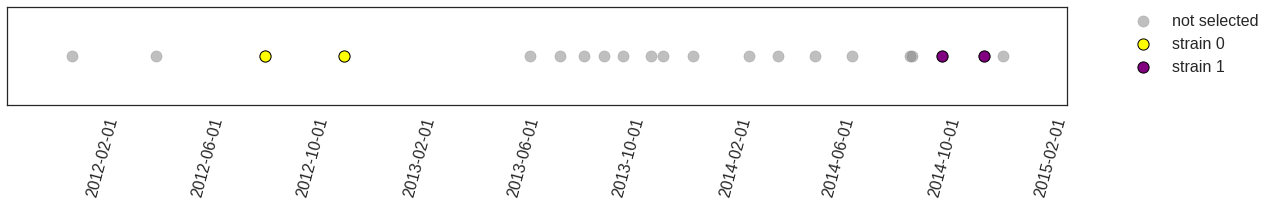

In [177]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

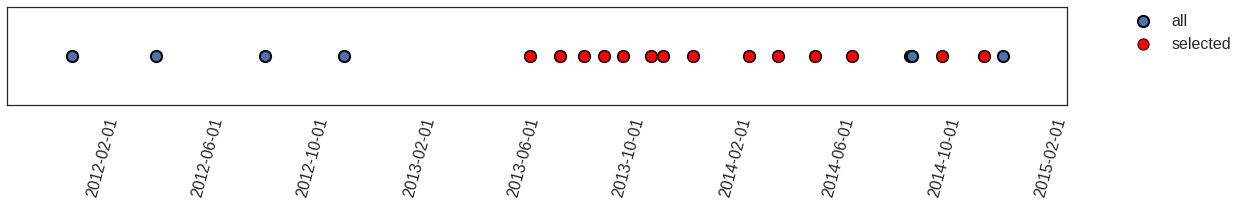

In [178]:
list_to_remain = list(range(4,16)) + list(range(18,20))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [179]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
36877 remained


In [180]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

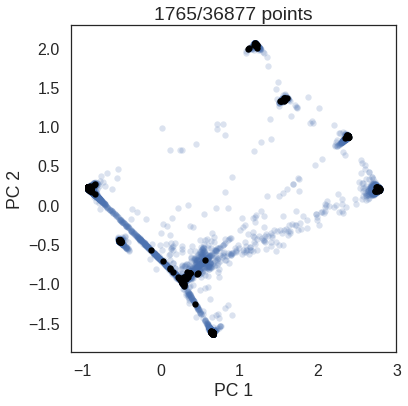

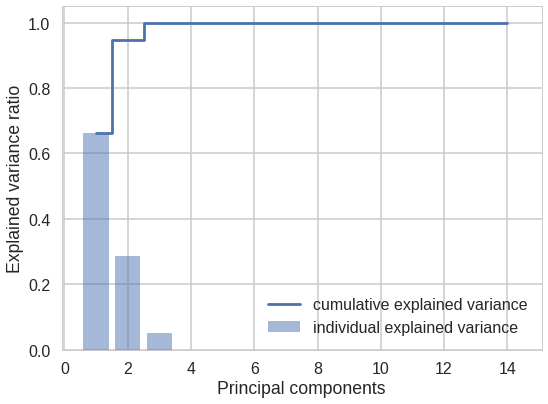

In [181]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 7
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    1.
  0.98]
1 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.98  1.    1.    1.    0.
  0.02]
2 [ 0.99  1.    0.99  1.    1.    1.    1.    1.    0.    0.    0.    0.    1.
  0.98]
3 [ 1.    1.    1.    1.    1.    1.    1.    1.    0.99  1.    1.    1.    0.
  0.02]
4 [ 0.99  1.    1.    1.    1.    1.    1.    1.    0.    0.    0.    0.    0.
  0.  ]
5 [ 0.    0.    0.    0.    0.02  0.01  0.04  0.    0.    0.    0.    0.01
  0.    0.  ]
6 [ 0.01  0.01  0.01  0.    0.    0.    0.    0.    0.99  1.    1.    1.    1.
  1.  ]


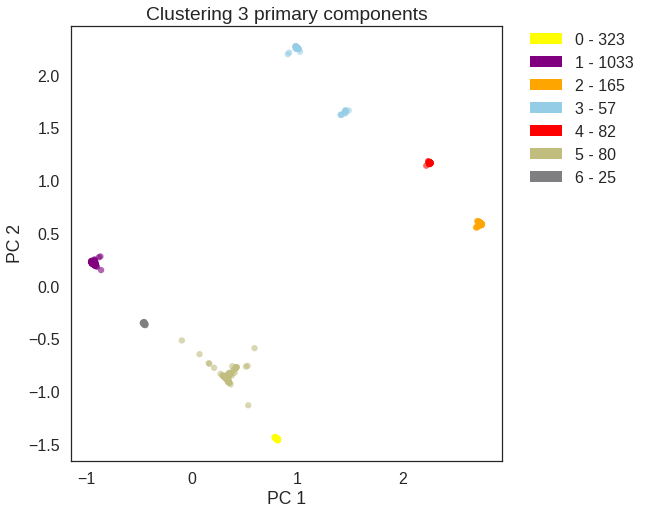

In [188]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=7, num_of_comp=3)

In [189]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=0)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.02  0.01  0.04  0.    0.    0.    0.    0.01
  0.    0.  ] 

   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   0.98  --  1
   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.98    1.0    1.0    1.0    0.0   0.02  --  2
  0.99    1.0    1.0    1.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  --  3
  0.99    1.0   0.99    1.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    1.0   0.98  --  [1, 3]
   1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   0.99    1.0    1.0    1.0    0.0   0.02  --  [2, 3]
  0.01   0.01   0.01    0.0    0.0    0.0    0.0    0.0   0.99    1.0    1.0    1.0    1.0    1.0  --  [1, 2]


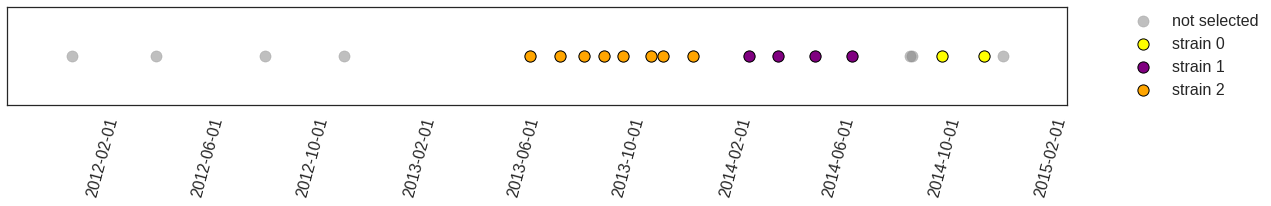

In [190]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

# Объединяем

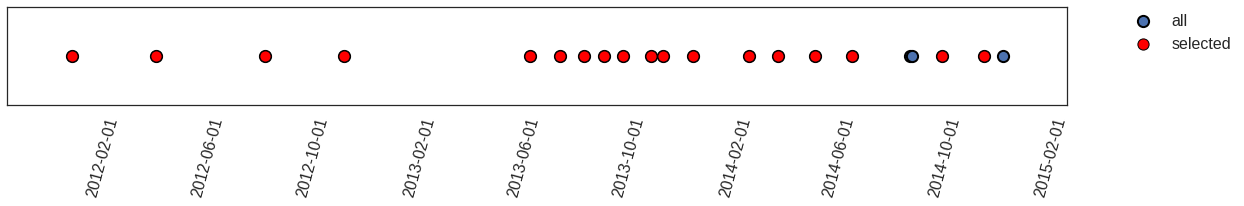

In [192]:
list_to_remain = list(range(16)) + [18,19]
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [193]:
strains = [""] * 6
strains[0] = [1] + [0]*15 + [0]*2
strains[1] = [0, 1] + [0]*14 + [0]*2
strains[2] = [0,0] + [1,1] + [0]*12 + [0]*2
strains[3] = [0]*4 + [1]*8 + [0]*4 + [0]*2
strains[4] = [0]*12 + [1]*4 + [0]*2
strains[5] = [0]*16 + [1]*2

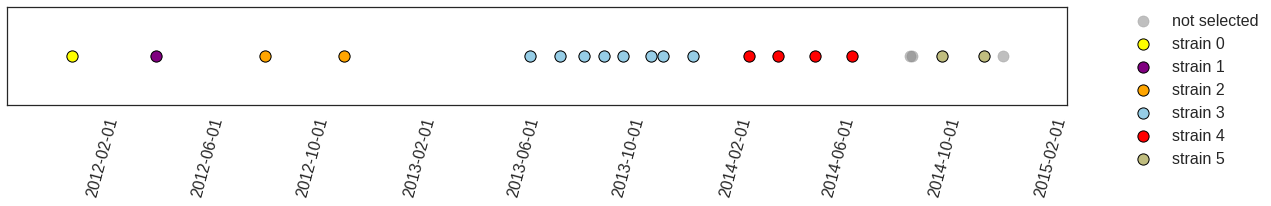

In [194]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

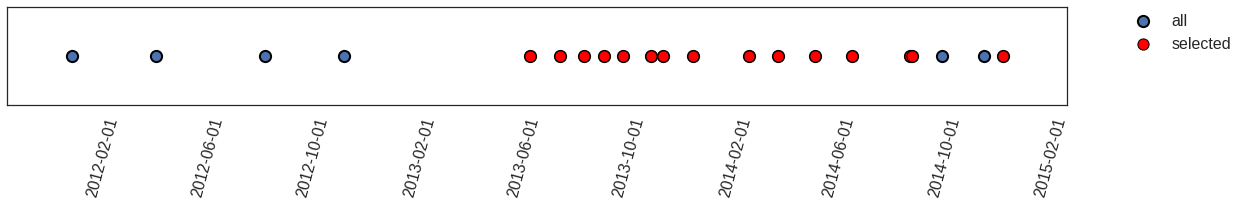

In [196]:
list_to_remain = list(range(4,16)) + [16, 17, 20]
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [197]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
44330 remained


In [198]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

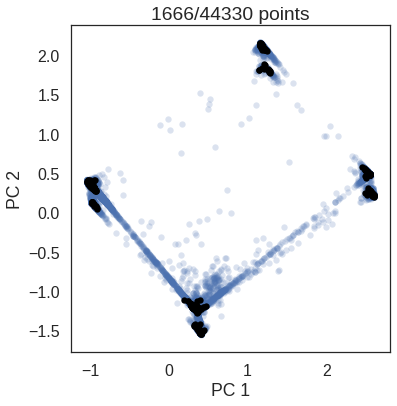

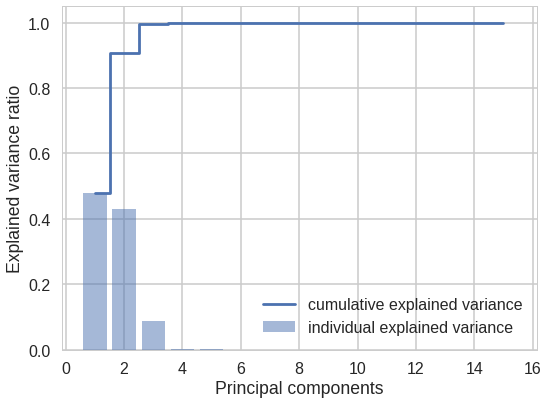

In [199]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))

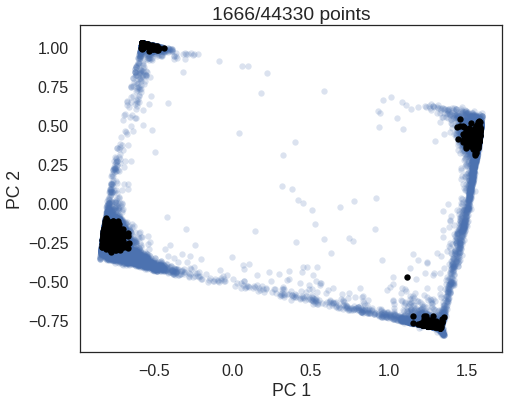

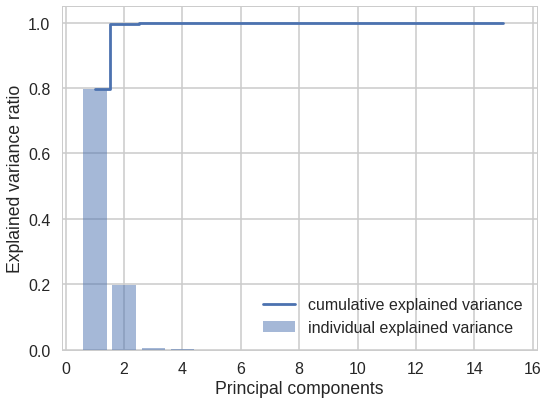

In [200]:
f = normalize(x, r)
f_pca = PCA(n_components=2).fit(f).transform(f)
draw_PCA(f_pca, good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 8
0 outliers

Medians in clusters:
0 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.98  1.    1.    1.
  0.21  0.03  0.9 ]
1 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01
  0.    0.    0.21]
2 [ 0.99  1.    0.99  1.    1.    1.    1.    1.    0.    0.    0.    0.    0.
  0.01  0.  ]
3 [ 1.    1.    1.    1.    1.    1.    1.    1.    0.97  1.    1.    1.    0.2
  0.03  1.  ]
4 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.02  0.    0.    0.
  0.79  0.96  0.  ]
5 [ 1.    1.    0.99  1.    1.    1.    1.    1.    0.02  0.    0.    0.
  0.79  0.97  0.  ]
6 [ 0.01  0.01  0.01  0.    0.    0.    0.    0.    1.    1.    1.    1.    1.
  0.99  1.  ]
7 [ 1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.    1.
  1.    0.82]


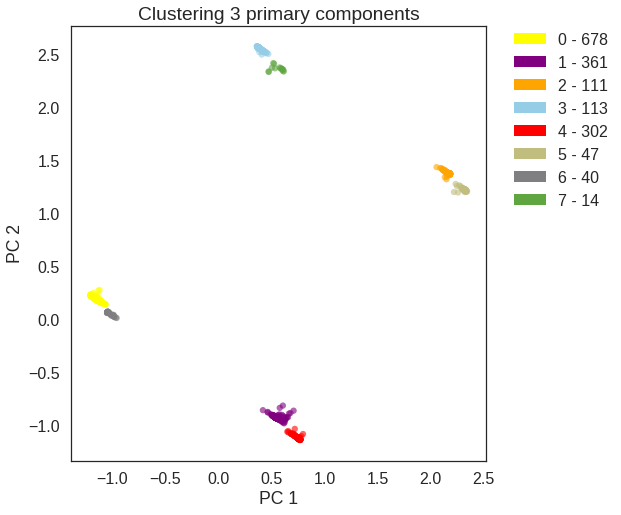

In [201]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=8, num_of_comp=3)

In [203]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=1)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.01
  0.    0.    0.21] 

   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.98    1.0    1.0    1.0   0.21   0.03    0.9  --  1
  0.99    1.0   0.99    1.0    1.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0   0.01    0.0  --  2
   0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   0.02    0.0    0.0    0.0   0.79   0.96    0.0  --  3
   1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   0.97    1.0    1.0    1.0    0.2   0.03    1.0  --  [1, 2]
   1.0    1.0   0.99    1.0    1.0    1.0    1.0    1.0   0.02    0.0    0.0    0.0   0.79   0.97    0.0  --  [2, 3]
  0.01   0.01   0.01    0.0    0.0    0.0    0.0    0.0    1.0    1.0    1.0    1.0    1.0   0.99    1.0  --  [1, 3]
   1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0    1.0   0.82  --  [1, 2, 3]


###### Здесь важно, что в образцах 16 и 17 ДВА ШТАММА.

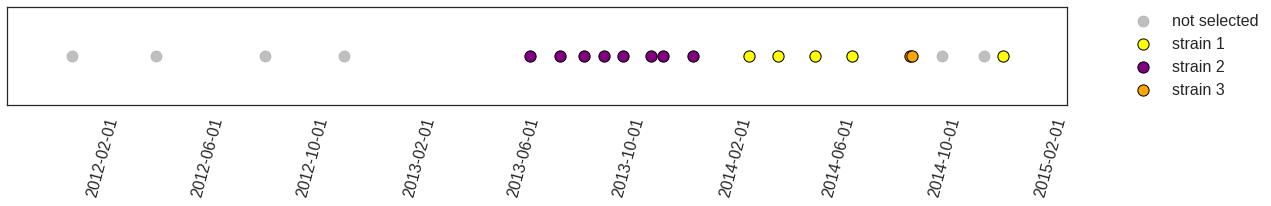

In [206]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

# Объединяем

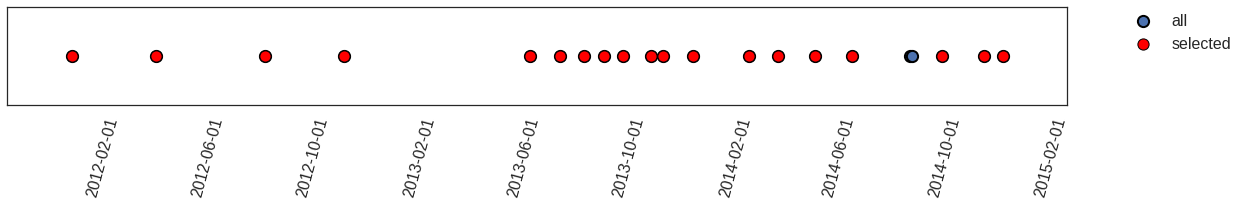

In [207]:
list_to_remain = list(range(16)) + [18,19,20]
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [208]:
strains = [""] * 6
strains[0] = [1] + [0]*15 + [0]*2 + [0]
strains[1] = [0, 1] + [0]*14 + [0]*2 + [0]
strains[2] = [0,0] + [1,1] + [0]*12 + [0]*2 + [0]
strains[3] = [0]*4 + [1]*8 + [0]*4 + [0]*2 + [0]
strains[4] = [0]*12 + [1]*4 + [0]*2 + [1]
strains[5] = [0]*16 + [1]*2 + [0]

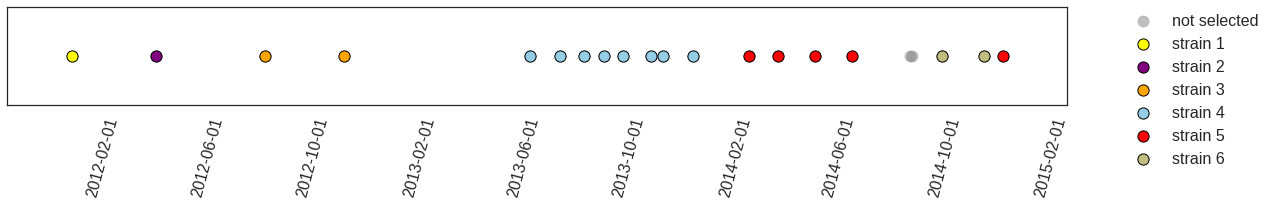

In [209]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

## И еще другие

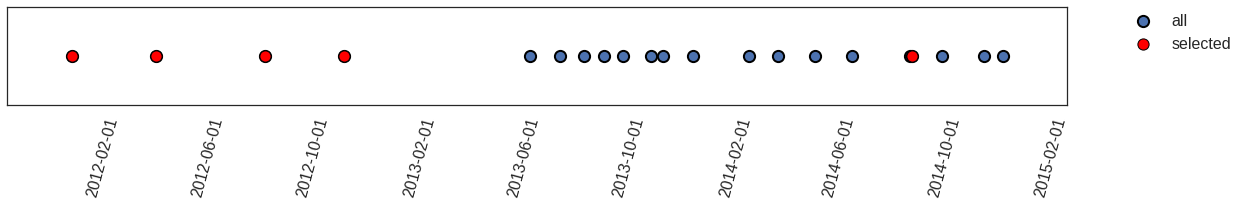

In [217]:
list_to_remain = list(range(4)) + [17]
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [218]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
70992 remained


In [219]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

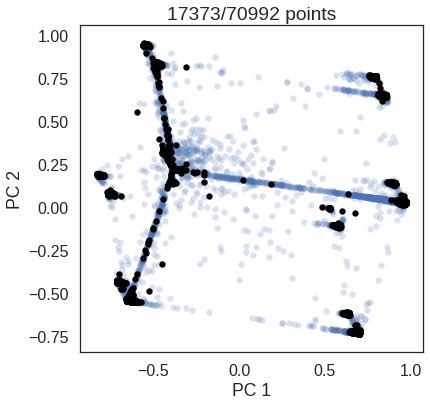

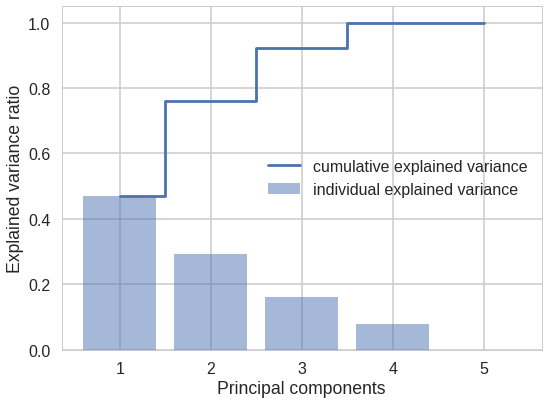

In [220]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))


Number of clusters:
 16
0 outliers

Medians in clusters:
0 [ 1.    0.    0.    0.    0.01]
1 [ 0.    1.    0.99  1.    0.  ]
2 [ 0.  1.  0.  0.  0.]
3 [ 0.    0.    0.98  1.    0.  ]
4 [ 0.    0.    0.    0.    0.96]
5 [ 1.    0.    1.    1.    0.02]
6 [ 1.    1.    1.    1.    0.03]
7 [ 1.    1.    0.01  0.    0.02]
8 [ 0.    0.    0.    0.    0.05]
9 [ 0.    1.    0.    0.    0.97]
10 [ 1.    0.    1.    1.    0.99]
11 [ 0.    0.    0.99  1.    0.97]
12 [ 1.    0.    0.    0.    0.99]
13 [ 0.    1.    0.99  1.    0.97]
14 [ 1.    1.    0.01  0.    0.99]
15 [ 1.    1.    1.    1.    0.94]


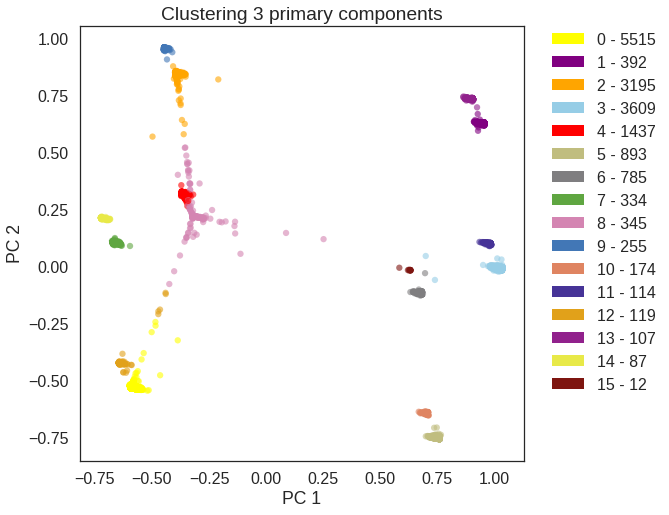

In [221]:
f = np.divide(x, r)[good_coverage_ind]
clusters = clusterization_kmeans(f, k=16, num_of_comp=3)

In [223]:
clusters_centers = [np.median(clstr, axis=0) for clstr in clusters]

strains = brute_force(clusters_centers, bad_samples=0)

Cluster for zero profiles:
 [ 0.    0.    0.    0.    0.05] 

   1.0    0.0    0.0    0.0   0.01  --  1
   0.0    1.0    0.0    0.0    0.0  --  2
   0.0    0.0   0.98    1.0    0.0  --  3
   0.0    0.0    0.0    0.0   0.96  --  4
   0.0    1.0   0.99    1.0    0.0  --  [2, 3]
   1.0    0.0    1.0    1.0   0.02  --  [1, 3]
   1.0    1.0    1.0    1.0   0.03  --  [1, 2, 3]
   1.0    1.0   0.01    0.0   0.02  --  [1, 2]
   0.0    1.0    0.0    0.0   0.97  --  [2, 4]
   1.0    0.0    1.0    1.0   0.99  --  [1, 3, 4]
   0.0    0.0   0.99    1.0   0.97  --  [3, 4]
   1.0    0.0    0.0    0.0   0.99  --  [1, 4]
   0.0    1.0   0.99    1.0   0.97  --  [2, 3, 4]
   1.0    1.0   0.01    0.0   0.99  --  [1, 2, 4]
   1.0    1.0    1.0    1.0   0.94  --  [1, 2, 3, 4]


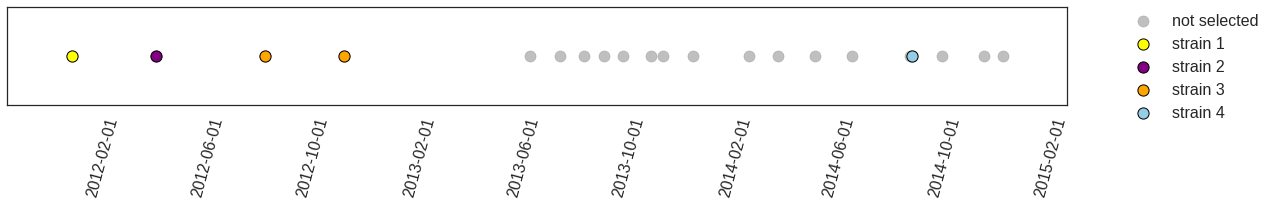

In [224]:
plot_strains_on_dates(dates_all, list_to_remain, strains)

# Объединяем

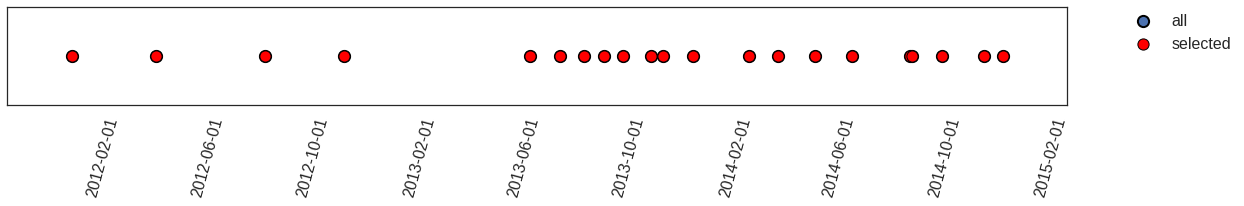

In [225]:
list_to_remain = list(range(21))
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [427]:
strains = [""] * 7
strains[0] = [1] + [0]*15 + [0]*2 + [0]*2 + [0]
strains[1] = [0, 1] + [0]*14 + [0]*2 + [0]*2 + [0]
strains[2] = [0,0] + [1,1] + [0]*12 + [0]*2 + [0]*2 + [0]
strains[3] = [0]*4 + [1]*8 + [0]*4 + [0]*2 + [0]*2 + [0]
strains[4] = [0]*12 + [1]*4 + [0]*2 + [0]*2 + [1]
strains[6] = [0]*16 + [0]*2 + [1]*2 + [0]
strains[5] = [0]*16 + [1]*2 + [0]*2 + [0]

In [428]:
import math

In [430]:
def plot_final_strains_on_dates(dates, strains):
    plt.figure(figsize=(19, 2))
    ax=plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)

    timestampes_all = [time.mktime(datetime.datetime.strptime(s, "%Y_%m_%d").timetuple()) for s in dates]
    points_all = [dt.datetime.fromtimestamp(ts) for ts in timestampes_all]

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=75)
    ax = plt.gca()
    xfmt = md.DateFormatter('%Y-%m-%d')
    ax.xaxis.set_major_formatter(xfmt)
    ax.set_yticklabels([])
    
    colors = ['yellow', 'purple', 'orange', '#96cde6', 'red', '#c0bd7f', '#5fa641', '#d485b2', 
              '#4277b6', '#df8461', '#463397', '#e1a11a', '#91218c', '#e8e948', '#7e1510',
              '#92ae31', '#6f340d', '#d32b1e', '#2b3514']
    
    for k in range(len(strains)):
        strain = strains[k]
        points_cur_strain = [points_all[i] for i in range(len(points_all)) if strain[i] == 1]
        if k < 5:
            plt.scatter(points_cur_strain, [0] * len(points_cur_strain), color=colors[k], 
                        edgecolor='black', linewidth='1', label="strain %s" % (k+1), s=150);
        elif k == 5:
            print(points_cur_strain)
            
            sizes = [200, 200, 200]
            
            plt.scatter(points_cur_strain[0], [0], color=colors[k], 
                        edgecolor='black', linewidth='1', label="strain %s" % (k+1), s=150)
            
            # first define the ratios
            r1 = 0.21       
            r2 = r1 + 0.79  
            x = [0] + np.cos(np.linspace(0, 2*math.pi*r1, 100)).tolist()
            y = [0] + np.sin(np.linspace(0, 2*math.pi*r1, 100)).tolist()
            xy1 = list(zip(x, y))
            s1 = max(max(x), max(y))
            x = [0] + np.cos(np.linspace(2*math.pi*r1, 2*math.pi*r2, 100)).tolist()
            y = [0] + np.sin(np.linspace(2*math.pi*r1, 2*math.pi*r2, 100)).tolist()
            xy2 = list(zip(x, y))
            s2 = max(max(x), max(y))
            plt.scatter(points_cur_strain[0], [0], marker=(xy1, 0),
                       s=[s1*s1*_ for _ in sizes], facecolor='red')
            plt.scatter(points_cur_strain[0], [0], marker=(xy2, 0),
                       s=[s2*s2*_ for _ in sizes], facecolor=colors[k])
 
            # first define the ratios
            r1 = 0.000001     
            r2 = r1 + 0.9999999
            x = [0] + np.cos(np.linspace(0, 2*math.pi*r1, 100)).tolist()
            y = [0] + np.sin(np.linspace(0, 2*math.pi*r1, 100)).tolist()
            xy1 = list(zip(x, y))
            s1 = max(max(x), max(y))
            x = [0] + np.cos(np.linspace(2*math.pi*r1, 2*math.pi*r2, 100)).tolist()
            y = [0] + np.sin(np.linspace(2*math.pi*r1, 2*math.pi*r2, 100)).tolist()
            xy2 = list(zip(x, y))
            s2 = max(max(x), max(y))
            plt.scatter(points_cur_strain[1], [0.4], marker=(xy1, 0),
                       s=[s1*s1*_ for _ in sizes], facecolor='red')
            plt.scatter(points_cur_strain[1], [0.4], marker=(xy2, 0),
                       s=[s2*s2*_ for _ in sizes], facecolor=colors[k])
            
            #plt.scatter(points_cur_strain, [0,0.3], color=colors[k], 
            #            edgecolor='black', linewidth='1', label="strain %s" % (k+1), s=150);
        else:
            plt.scatter(points_cur_strain, [0] * len(points_cur_strain), color=colors[k], 
                        edgecolor='black', linewidth='1', label="strain %s" % (k+1), s=150);
        
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylim((-1,1))

[datetime.datetime(2014, 8, 22, 0, 0), datetime.datetime(2014, 8, 25, 0, 0)]


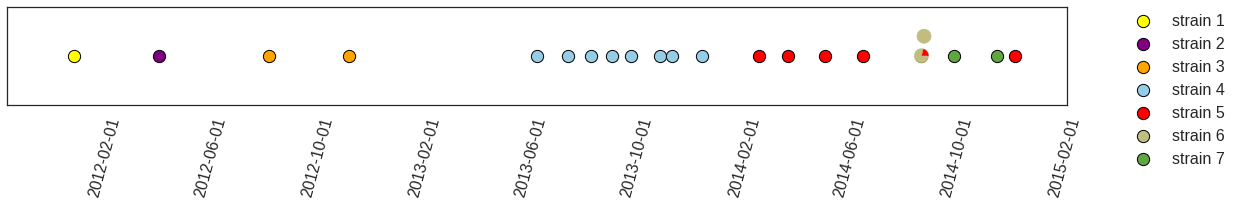

In [431]:
plot_final_strains_on_dates(dates_all, strains)

# Табличка с частотами

In [400]:
strains[4][16] = 0.21
strains[4][17] = 0.03
strains[4][20] = 0.9
strains[4][19] = 0.02

strains[5][16] = 0.79
strains[5][17] = 0.97

strains[6][19] = 0.98

for strain in strains:
    print(" ".join(['%4s' % freq for freq in strain]))

   1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    1    1    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   0    0    0    0    1    1    1    1    1    1    1    1    0    0    0    0    0    0    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    1    1    1    1 0.21 0.03    0 0.02  0.9
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0 0.79 0.97    0    0    0
   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    1 0.98    0


# Генотипы

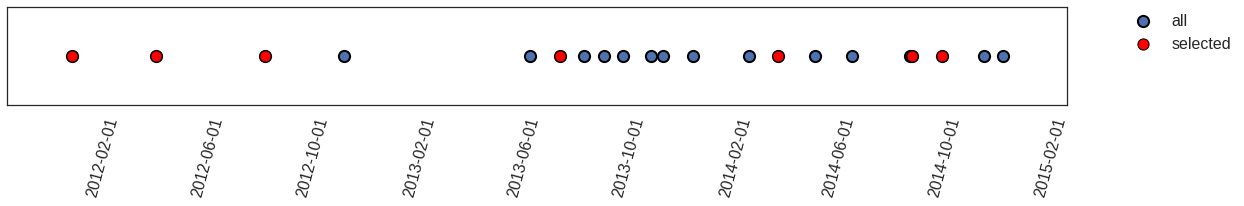

In [401]:
list_to_remain = [0, 1, 2, 5, 13, 17, 18]
list_to_delete = list(set(range(21)) - set(list_to_remain))

plot_dates(dates_all, list_to_remain)

In [402]:
r = np.delete(r_all_smpls, list_to_delete, axis=1)
x = np.delete(x_all_smpls, list_to_delete, axis=1)

x, r = delete_almost_zero(x, r)

Delete zero and almost zero profiles:
83129 remained


In [403]:
good_coverage_ind = filter_by_coverage(r, 25, 1)

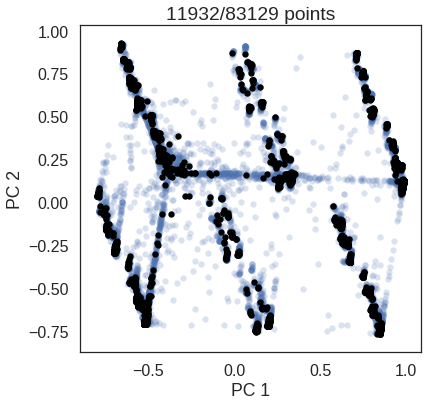

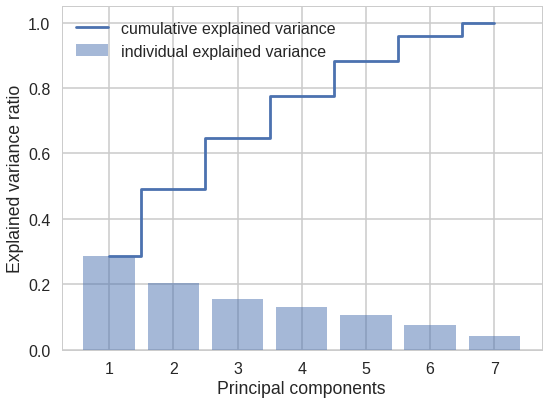

In [405]:
f = np.divide(x, r)
draw_PCA(PCA(n_components=2).fit(f).transform(f), 
         good_coverage_ind)
plot_explained_variance(f[good_coverage_ind], len(list_to_remain))

In [406]:
f_rounded = np.rint(f)

genotypes = []
for i in range(len(f_rounded[0])):
    genotypes.append(f_rounded[:, i])

In [407]:
import scipy.spatial.distance as dist

In [408]:
for d in dist.squareform(dist.pdist(genotypes, 'hamming')):
    print(d)

[ 0.    0.5   0.51  0.41  0.23  0.44  0.44]
[ 0.5   0.    0.45  0.29  0.44  0.3   0.3 ]
[ 0.51  0.45  0.    0.38  0.47  0.41  0.4 ]
[ 0.41  0.29  0.38  0.    0.36  0.18  0.11]
[ 0.23  0.44  0.47  0.36  0.    0.39  0.38]
[ 0.44  0.3   0.41  0.18  0.39  0.    0.2 ]
[ 0.44  0.3   0.4   0.11  0.38  0.2   0.  ]


In [373]:
len(genotypes)

7

In [420]:
with open("smarr_allignment", "w") as f:
    for i in range(len(genotypes)):
        f.write("\n>Strain_%s\n" % (i+1))
        for j in range(len(genotypes[i])):
            if j % 20 == 0:
                site = genotypes[i][j]
                if site == 1:
                    f.write("A")
                else:
                    f.write("G")
    #print()

In [424]:
with open("smarr_boolean_genotypes.txt", "w") as f:
    for i in range(len(genotypes)):
        f.write("\n>Strain_%s\n" % (i+1))
        for j in range(len(genotypes[i])):
            site = genotypes[i][j]
            f.write(str(int(site)))

/home/makseshina/tools/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


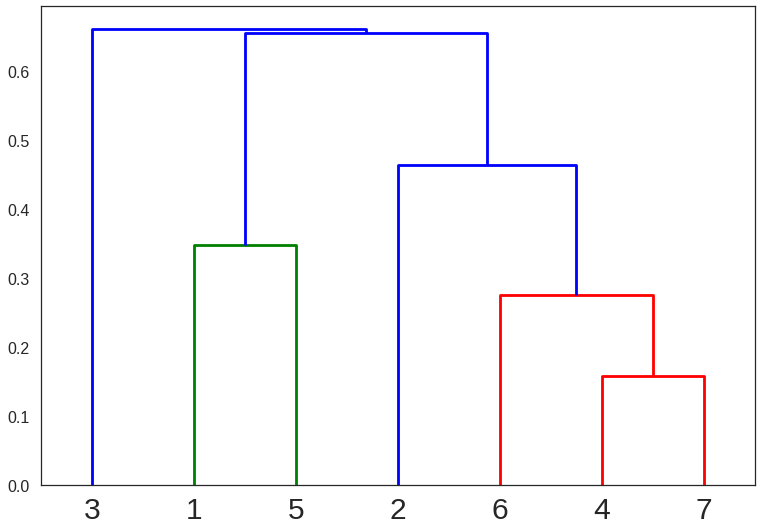

In [416]:
import numpy as np

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

mat = np.array([[0.0, 2.0, 0.1], [2.0, 0.0, 2.0], [0.1, 2.0, 0.0]])
dists = dist.squareform(dist.pdist(genotypes, 'hamming'))
linkage_matrix = linkage(dists, "single")
dendrogram(linkage_matrix, labels=[str(i) for i in range(1,8)], leaf_font_size=30);